### Load report

In [1]:
import pandas as pd
import numpy as np

class FinancialReport():
    FINANCIAL_REPORT_PATH = [
        "../database/financial_report/date/",
        "../database/financial_report/balance/",
        "../database/financial_report/bill/",
        "../database/financial_report/flow/",
    ]
    
    def __init__(self) -> None:
        pass

    def __read_sub_reports(self, ticker: str):
        self._sub_report = [pd.read_csv("{}{}.csv".format(path, ticker)) 
                            for path in FinancialReport.FINANCIAL_REPORT_PATH]
    
    def __get_first_common_element(self, l1, l2):
        for v in l1:
            if v in l2:
                return v
            
    def __get_last_common_element(self, l1, l2):
        for v in reversed(l1):
            if v in l2:
                return v
            
    def __remove_duplicate_year(self):
        full_date_publication = self._sub_report[0]["Date"].to_list()
        year_publication = [date.split("-")[0] for date in full_date_publication]
        duplicate_rows = []
        for i in range(len(year_publication)-1):
            for j in range(i+1, len(year_publication)):
                if year_publication[i] == year_publication[j]:
                    duplicate_rows.append(j)
        
        self._sub_report[0] = self._sub_report[0].drop(duplicate_rows)
        

    def __replace_data(self):
        self.__remove_duplicate_year()
        full_date_publication = self._sub_report[0]["Date"].to_list()
        year_publication = [date.split("-")[0] for date in full_date_publication]
        # Find earliest common element
        first_value = self.__get_first_common_element(year_publication, self._report.columns.to_list())
        last_value = self.__get_last_common_element(year_publication, 
                                                   self._report.columns.to_list())  
        data_range = [str(i) for i in range(int(first_value), int(last_value) + 1)]
        columns = self._report.columns.to_list()
        col_to_drop = list(set(columns).difference(data_range))
        if len(col_to_drop) > 0:
            self._report = self._report.drop(col_to_drop, axis=1)

        new_column = full_date_publication[year_publication.index(first_value):
                                           year_publication.index(last_value) + 1]

        self._report.columns = new_column

    def __concatenate_sub_reports(self):
        column_name = self._sub_report[1].iloc[0, 1:].astype("str").to_list()
        index_name = []
        for rep in self._sub_report[1:]:
            index_name += rep.iloc[1:,0].to_list() 

        report = np.vstack([rep.iloc[1:,1:].to_numpy() for rep in self._sub_report[1:]])
        self._report = pd.DataFrame(report, index=index_name, columns=column_name)

    def get_report(self, ticker: str) -> pd.DataFrame:
        self.__read_sub_reports(ticker)
        self.__concatenate_sub_reports()
        self.__replace_data()
        return self._report.transpose()

    

### Chemical sector

In [2]:
import pandas as pd

PATH_TO_COMPANY_LIST = [
    "../database/company_list/wig_chemia.csv",
    "../database/company_list/wig_odziez.csv",
    "../database/company_list/wig_spozywczy.csv",
]


company_name = pd.concat([pd.read_csv(path) for path in PATH_TO_COMPANY_LIST])
report_df = [FinancialReport().get_report(ticker) for ticker in company_name["TICKER"]]
report_corr = [df.corr().to_numpy() for df in report_df]


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def show_correlation_matrix(corr_matrix: np.ndarray, labels: list, dec: int = 1):
    fig, ax = plt.subplots()
    im = ax.imshow(corr_matrix)

    ax.set_xticks(np.arange(len(labels)), labels=labels)
    ax.set_yticks(np.arange(len(labels)), labels=labels)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    for i in range(corr_matrix.shape[0]):
        for j in range(corr_matrix.shape[1]):
            text = ax.text(j, i, round(corr_matrix[i, j], dec),
                        ha="center", va="center", color="w")
            
    fig.set_size_inches(10,10)
    fig.tight_layout()
    plt.show()

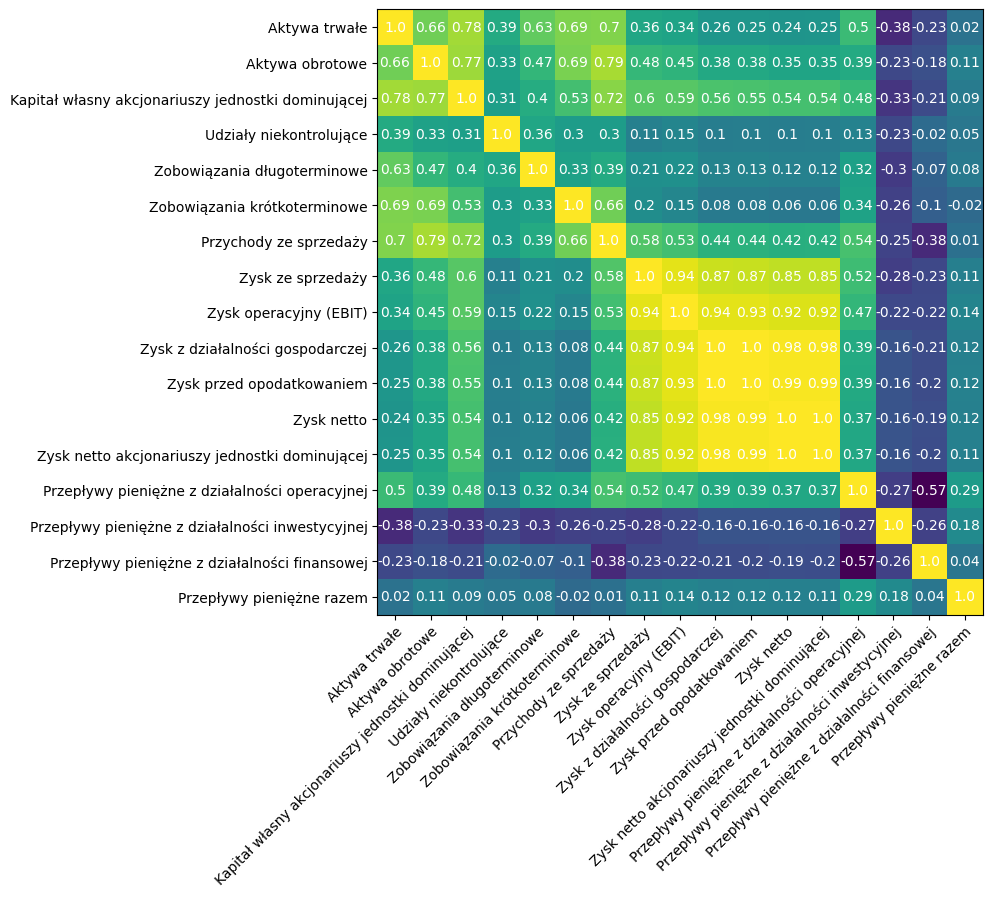

In [16]:
masked_report_corr = np.ma.masked_array(report_corr, np.isnan(report_corr))
masked_corr_matrix = np.ma.mean(masked_report_corr, axis=0)

show_correlation_matrix(masked_corr_matrix, report_df[0].columns, 2)

### List highly correlated data

Za zmienne silnie skorelowane uważamy te dla których współczynnik korelacji $>0.7$

In [18]:
report_df[0].columns

Index(['Aktywa trwałe', 'Aktywa obrotowe',
       'Kapitał własny akcjonariuszy jednostki dominującej',
       'Udziały niekontrolujące', 'Zobowiązania długoterminowe',
       'Zobowiązania krótkoterminowe', 'Przychody ze sprzedaży',
       'Zysk ze sprzedaży', 'Zysk operacyjny (EBIT)',
       'Zysk z działalności gospodarczej', 'Zysk przed opodatkowaniem',
       'Zysk netto', 'Zysk netto akcjonariuszy jednostki dominującej',
       'Przepływy pieniężne z działalności operacyjnej',
       'Przepływy pieniężne z działalności inwestycyjnej',
       'Przepływy pieniężne z działalności finansowej',
       'Przepływy pieniężne razem'],
      dtype='object')

In [19]:
highly_correlated = [
    'Kapitał własny akcjonariuszy jednostki dominującej',
    'Przychody ze sprzedaży',
    'Zysk ze sprzedaży', 
    'Zysk operacyjny (EBIT)',
    'Zysk z działalności gospodarczej', 
    'Zysk przed opodatkowaniem',
    'Zysk netto akcjonariuszy jednostki dominującej',
    ]

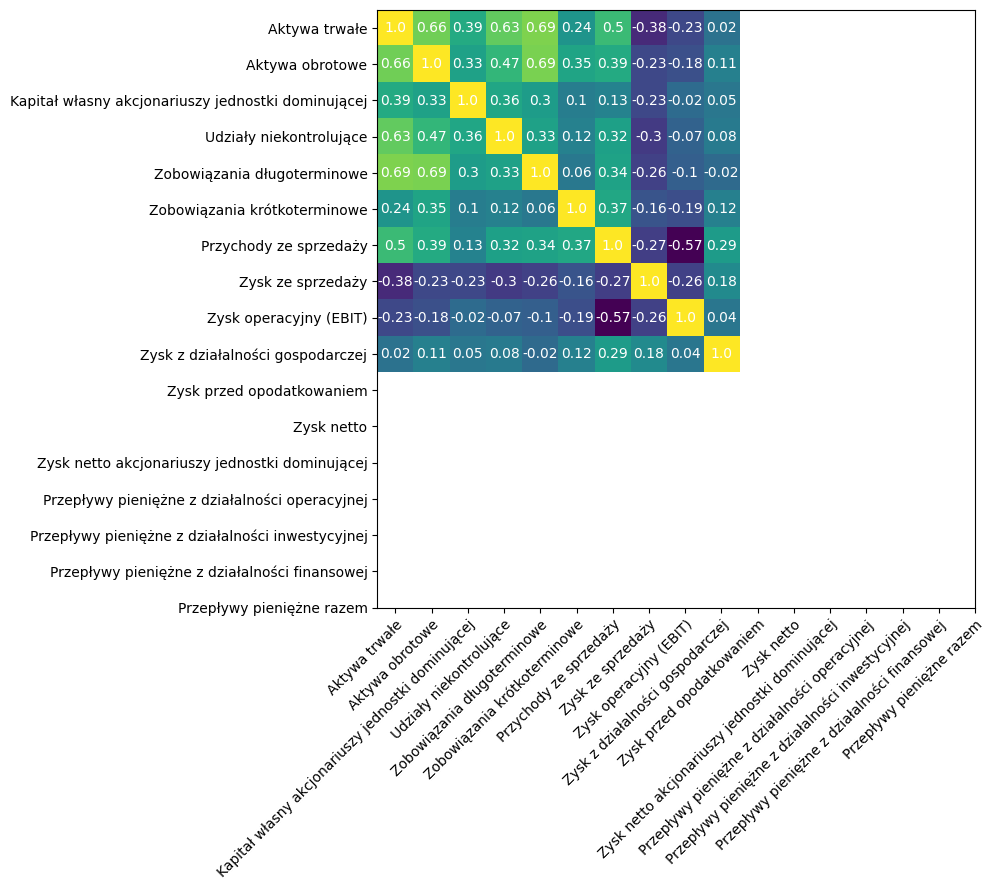

In [22]:
filtered_report_df = [report.drop(columns=highly_correlated) for report in report_df]
filtered_report_corr = [df.corr().to_numpy() for df in filtered_report_df]

masked_report_corr = np.ma.masked_array(filtered_report_corr, np.isnan(filtered_report_corr))
masked_corr_matrix = np.ma.mean(masked_report_corr, axis=0)

show_correlation_matrix(masked_corr_matrix, filtered_report_df[0].columns, 2)